In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('dark_background')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

In [ ]:
df = pd.read_csv("../Datasets/Cuvinte-Eliminate/train-punct-stop-1000.csv")
df=df.dropna()
df=df.sample(n=100000)
#df=df.drop(["news_title","url","reddit_title"],axis=1)
df_train=df


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-02-24 08:54:58.769992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 08:54:59.685469: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 08:54:59.686739: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
df = pd.read_csv("../Datasets/Stem-Cuvinte-Eliminate/train-punct-stop-stem-200.csv")
df=df.dropna()
df_poz=df[df['sentiment'] == 2]
df_neg=df[df['sentiment'] == 0]
df_poz=df_poz.sample(500000)
df_neg=df_neg.sample(500000)
df = pd.concat([df_poz,df_neg])
#df=df.drop(["news_title","url","reddit_title"],axis=1)
df_train=df

In [4]:
X_train = df_train['text']

max phrase len: 141


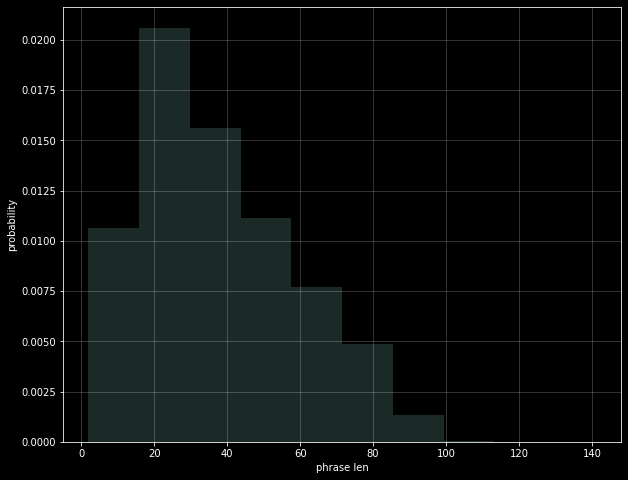

In [5]:
phrase_len = X_train.apply(lambda p: len(p.split(' ')))
max_phrase_len = phrase_len.max()
print('max phrase len: {0}'.format(max_phrase_len))
plt.figure(figsize = (10, 8))
plt.hist(phrase_len, alpha = 0.2, density = True)
plt.xlabel('phrase len')
plt.ylabel('probability')
plt.grid(alpha = 0.25)

In [6]:
y_train = df_train['sentiment'].values

In [7]:
train_labels=[]
for i in range(0,len(y_train)):
    train_labels.append([0,0])

In [8]:
len(y_train)

1000000

In [9]:
train_labels=np.array(train_labels)

In [10]:
y_train

array([2, 2, 2, ..., 0, 0, 0])

In [11]:
for i in range(0,len(y_train)):
    if y_train[i] == 0:
        train_labels[i][0]=1
    else:
        train_labels[i][1]=1

In [12]:
train_labels

array([[0, 1],
       [0, 1],
       [0, 1],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [ ]:
#max_words = 16384
max_words = 32768
tokenizer = Tokenizer(num_words = max_words)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 128)

In [14]:
X_train = tokenizer.texts_to_sequences(X_train)
X_train = pad_sequences(X_train, maxlen = 128)

In [15]:
print(X_train[0])
print(train_labels[0])

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0   10   72    8   22  685   79
  540  108  300   71   60 3947  254   25   79   16    6   21  113   28
  288 4885]
[0 1]


In [16]:
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim = 32768, output_dim = 256, input_length = 128))
model_lstm.add(SpatialDropout1D(0.75))
model_lstm.add(LSTM(256, dropout = 0.75, recurrent_dropout = 0.75))
model_lstm.add(Dense(128, activation = 'relu'))
model_lstm.add(Dropout(0.75))
model_lstm.add(Dense(2, activation = 'softmax'))
model_lstm.compile(
    loss='categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

2022-02-24 08:56:17.686403: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-02-24 08:56:17.687934: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 08:56:17.689222: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-24 08:56:17.690499: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [17]:
history = model_lstm.fit(
    X_train,
    train_labels,
    validation_split = 0.1,
    epochs = 3,
    batch_size = 256
)

Epoch 1/3
3516/3516 [==============================] - 1969s 556ms/step - loss: 0.3572 - accuracy: 0.8467 - val_loss: 0.3281 - val_accuracy: 0.8591
Epoch 2/3
3516/3516 [==============================] - 1972s 561ms/step - loss: 0.2953 - accuracy: 0.8793 - val_loss: 0.3290 - val_accuracy: 0.8706
Epoch 3/3
3516/3516 [==============================] - 1944s 553ms/step - loss: 0.2765 - accuracy: 0.8886 - val_loss: 0.2574 - val_accuracy: 0.8922


(Text(0, 0.5, 'Cross-entropy loss'),)

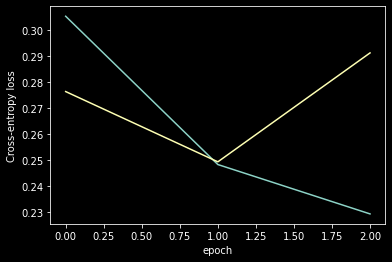

In [18]:
plt.plot(history.history['loss'], label='train loss'),
plt.plot(history.history['val_loss'], label='val loss'),
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss"),

In [ ]:
    plt.plot(history.history['accuracy'], label='train accuracy'),
    plt.plot(history.history['val_accuracy'], label='val accuracy'),
    plt.xlabel("epoch"),
    plt.ylabel("accuracy"),
    plt.legend();

In [18]:
model_lstm.save('./Model-200-drop75/')

2022-02-24 10:51:11.887220: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./Model-200-drop75/assets


In [ ]:
import pickle
with open('tokenizer-200-nou.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [13]:
import pickle
with open('tokenizer-200-nou.pickle', 'rb') as handle:
      tokenizer = pickle.load(handle)